https://github.com/shm4771/Time_Series_Forecasting/blob/master/Sales_multiseries_random.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/media/wojciech/D6DE33C1DE339927/1A/Sales_Transactions_Dataset_Weekly.csv')
df.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40


kolumny po tym zawierają znormalizowane wartości

In [6]:
df = df.loc[:, :'W51']
df.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9


# przekonwertujemy te dane do postaci długiej metodą stapiania

In [7]:
#we will convert this data into long form using melt method
melt = pd.melt(df, id_vars=['Product_Code'], var_name='week', value_name='sale')
melt.head()

,Product_Code,week,sale
0,P1,W0,11
1,P2,W0,7
2,P3,W0,7
3,P4,W0,12
4,P5,W0,8


Wykreślmy dane z tygodnia 0

Text(0.5, 1.0, 'sales v/s weeks')

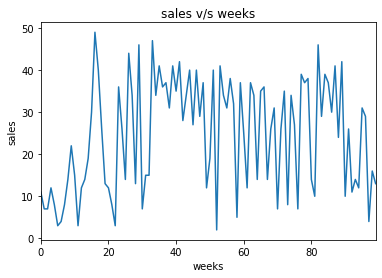

In [8]:
#Let's plot the week 0 data
melt[0:100]['sale'].plot()
plt.xlabel("weeks")
plt.ylabel("sales")
plt.title("sales v/s weeks")

# Jak widać, w danych nie ma dużej tendencji ani sezonowości
# dzięki temu możemy bezpośrednio korzystać z losowego lasu bez odstraszania
thus we can directly use the random forest without detrending

- tutaj musimy przełożyć wartości na liczby
- konwertujemy "P1" na 1 i "W1" na 1
- użyjemy metody wyodrębniania serii

In [9]:
melt.Product_Code = melt.Product_Code.str.extract(pat='(\d+)', expand=False).astype(int)
melt.week = melt.week.str.extract(pat='(\d+)', expand=False).astype(int)
melt.head()

,Product_Code,week,sale
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


- zbiór danych jest gotowy
- Teraz zajmiemy się inżynierią funkcji

- tworzyć cechy różnicowe
  - grupuj według kodu produktu i wykonuj zmianę w sprzedaży

In [11]:
melt_2 = melt.copy()
melt_2['Last_1_week_sales'] = melt_2.groupby(['Product_Code'])['sale'].shift(1)
melt_2['Last_1_week_diff'] = melt_2.groupby(['Product_Code'])['Last_1_week_sales'].diff(1)
melt_2['Last_2_week_sales'] = melt_2.groupby(['Product_Code'])['sale'].shift(2)
melt_2['Last_2_week_diff'] = melt_2.groupby(['Product_Code'])['Last_2_week_sales'].diff(1)
melt_3 = melt_2.dropna()

In [12]:
melt_3.head()

,Product_Code,week,sale,Last_1_week_sales,Last_1_week_diff,Last_2_week_sales,Last_2_week_diff
2433,1,3,8,10.0,-2.0,12.0,1.0
2434,2,3,2,3.0,-3.0,6.0,-1.0
2435,3,3,9,8.0,-3.0,11.0,4.0
2436,4,3,5,13.0,5.0,8.0,-4.0
2437,5,3,11,13.0,8.0,5.0,-3.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2f85235c90>,
      dtype=object)

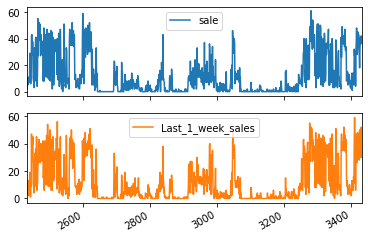

In [13]:
#Let's plot subplots to see if features make sense
melt_3[0:1000][['sale', 'Last_1_week_sales']].plot(subplots=True)

# Oczywiste jest, że wybrana funkcja ma przewidywalną moc sprzedaży

In [14]:
# error function
from sklearn.metrics import mean_squared_log_error
# we will take squareroot of the above error

In [15]:
# we will train model using the data till week 43 and predict sales for week 43 to 53
# We will use Root Mean Squared Log Error to compare results

#Base line model
base_error = []
for week in range(43, 52):
    y_true = melt_3[melt_3['week'] == week]['sale'].values #series to numpy array
    y_pred = melt_3[melt_3['week'] == week]['Last_1_week_sales'].values #series to numpy array
    
    error = np.sqrt(mean_squared_log_error(y_true, y_pred))
    base_error.append(error)
    
    print("rmsle for week ", week, "is: ", error)

rmsle for week  43 is:  0.5079204595063594
rmsle for week  44 is:  0.5340885312370197
rmsle for week  45 is:  0.5234709783234434
rmsle for week  46 is:  0.5001778165328664
rmsle for week  47 is:  0.4913800506226292
rmsle for week  48 is:  0.5058450575478508
rmsle for week  49 is:  0.505468359418995
rmsle for week  50 is:  0.5222037522547665
rmsle for week  51 is:  0.5524234818116678


# nasz model musi działać lepiej niż model podstawowy

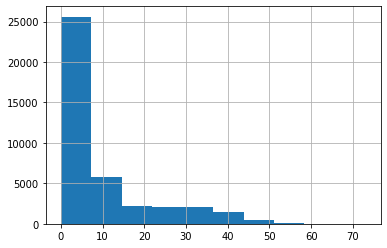

In [16]:
#Let's see the distribution of sales in data using histgram
melt_3['sale'].hist()

# Wyraźnie mówi, że sprzedaż większości pozycji jest dość niska

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [18]:
#regression model
model_error = []
for week in range(43, 52):
    train_data = melt_3[melt_3['week'] <= week]
    test_data = melt_3[melt_3['week'] == week]
    
    #training data
    x_train, y_train = train_data.drop('sale', axis=1), train_data['sale']
    x_test, y_test = test_data.drop('sale', axis=1), test_data['sale']
    
    #build model
    model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0) #-1 to use full cpu
    model.fit(x_train, y_train)
    
    #predict
    y_pred = model.predict(x_test)
    
    #compute error
    y_true = y_test.values
    error = np.sqrt(mean_squared_log_error(y_true, y_pred))
    model_error.append(error)
    
    #print and save error
    print("model rmsle for week ", week, "is: ", error)
    model_error.append(error)

model rmsle for week  43 is:  0.19196064636359297
model rmsle for week  44 is:  0.20944534147924374
model rmsle for week  45 is:  0.17806195470408948
model rmsle for week  46 is:  0.19864321744289742
model rmsle for week  47 is:  0.1907475927903476
model rmsle for week  48 is:  0.18508957061481576
model rmsle for week  49 is:  0.18728334887812695
model rmsle for week  50 is:  0.20519553736596002
model rmsle for week  51 is:  0.20092077644281509


# To jest niesamowite
 - pamiętaj, losowy las trenuj nasz model, używając błędu średniokwadratowego jako funkcji błędu.
 - Zmieńmy to na pierwiastek logarytmicznej średniej kwadratowej

In [19]:
#regression model -> rmlse as error function for training
model_error = []
for week in range(43, 52):
    train_data = melt_3[melt_3['week'] <= week]
    test_data = melt_3[melt_3['week'] == week]
    
    #training data
    x_train, y_train = train_data.drop('sale', axis=1), train_data['sale']
    x_test, y_test = test_data.drop('sale', axis=1), test_data['sale']
    
    #build model
    model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0) #-1 to use full cpu
    model.fit(x_train, np.log1p(y_train)) #1p to avoid log(0)
    
    #predict
    y_pred = np.expm1(model.predict(x_test)) #taking exp to use rmlse 
    
    #compute error
    y_true = y_test.values
    error = np.sqrt(mean_squared_log_error(y_true, y_pred))
    model_error.append(error)
    
    #print and save error
    print("model rmsle for week ", week, "is: ", error)
    model_error.append(error)

model rmsle for week  43 is:  0.1564556557299375
model rmsle for week  44 is:  0.16774113915527658
model rmsle for week  45 is:  0.15152515061482189
model rmsle for week  46 is:  0.165610022959734
model rmsle for week  47 is:  0.1537255961290627
model rmsle for week  48 is:  0.15944051888080238
model rmsle for week  49 is:  0.1600925386735658
model rmsle for week  50 is:  0.1698395910865882
model rmsle for week  51 is:  0.17223429934370152


<module 'matplotlib.pyplot' from '/home/wojciech/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

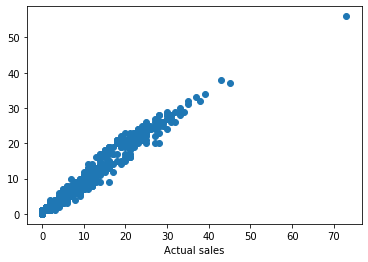

In [21]:
#As we can see the results are impressive.
#Let's plot the predicted sales and actual sales in scatter plot for week 51 predictions
true_sales = y_true #last entry
pred_sales = np.round(y_pred) #last entry
plt.scatter(true_sales, pred_sales)
plt.xlabel("Actual sales")
plt

- Model działa wystarczająco dobrze
- Widzimy, że sprzedaż jest wyższa niż 30/35, model daje wyższe błędy.
- Możemy zbadać dane i sprawdzić, czy istnieje jakiś trend lub inny powód tego

Pomysły na poprawę wydajności
1. Zbadaj przedmioty (sprzedaż), w przypadku których model nie działa zbyt dobrze
2. zwiększyć liczbę klasyfikatorów i stosować techniki workowania/wzmacniania/przycinania
3. Zwiększ więcej funkcji
4. Wypróbuj sieć neuronową i zestaw z GBM
5. Wypróbuj ulepszone algorytmy losowego lasu

Może sie przydać:

https://github.com/shm4771/Time_Series_Forecasting/blob/master/housing_price_forest.ipynb